# Double Pendulum

In [1]:
import ipywidgets as widgets
from casadi import *
import numpy as np
import matplotlib.pyplot as plt
import time


from matplotlib import rc 
import matplotlib.animation as animation
from collections import deque
from IPython.display import HTML

In [2]:
from functions_v3 import MS_functions_MHE, generate_meas, cnlls_solver, MHE


from animate_double import get_cart_x, get_cart_y, get_ball1_x, get_ball1_y, get_ball2_x, get_ball2_y, animate_double_pendulum

In [3]:
file = open("../plots/DoublePendulum_graphic.png", "rb")
image = file.read()
widgets.Image(
    value=image,
    format='png',
    width=200,
    height=600,
)

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x02\xaa\x00\x00\x01l\x08\x06\x00\x00\x00\x04\xdc\x9b…

## Implementing the model dynamics

In [4]:
# fixing parameters
g = 9.81
l1 = 0.323
l2 = 0.480
a1 = 0.2145
a2 = 0.223
m1 = 0.853
m2 = 0.510
J1 = 0.0126
J2 = 0.0185
#d1 = #0.005
#d2 = #0.005

In [5]:
# defining the rhs of the ODE system

# state variables
x1 = MX.sym('x1') #y
x2 = MX.sym('x2') #ydot
x3 = MX.sym('x3') #phi1
x4 = MX.sym('x4') #phi1dot
x5 = MX.sym('x5') #phi2
x6 = MX.sym('x6') #phi2dot
x = vertcat(x1,x2,x3,x4,x5,x6)

u = 0

#parameters
d1 = MX.sym('d1')
d2 = MX.sym('d2')
p = vertcat(d1,d2)

dM = (J1 + a1*a1*m1 + l1*l1*m2) * (J2 + a2*a2*m2) - a2*l1*m2*cos(x3-x5)*a2*l1*m2*cos(x3-x5)

f1 = (a1*m1 + l1*m2)*g*sin(x3) -a2*l1*m2*sin(x3-x5)*x6*x6 -d1*x4 - d2*(x4-x6) + (a1*m1+l1*m2)*cos(x3)*u

f2 = a2*g*m2*sin(x5) +a2*l1*m2*sin(x3-x5)*x4*x4 +d2*(x4-x6) +a2*m2*cos(x5)*u

# rhs
rhs_exp = vertcat(x2,
                  u,
                  x4,
                  1/dM *((J2+a2*a2*m2)*f1 -a2*l1*m2*cos(x3-x5)*f2),
                  x6,
                  1/dM *(-a2*l1*m2*cos(x3-x5)*f1+(J1+a1*a1*m1+l1*l1*m2)*f2))

rhs = Function('rhs',[x,p],[rhs_exp])

## Choose starting value, for which the measurements are obtained  

In [6]:
N = 10 #100 # number of integration steps
T = 0.5 #1 #10.0
L = 10 # -> insgesamt 5 sekunden

p_true = [0.05,0.1]

eps = 0.1
s0 = [0, 0, eps, 0, -0.5, 0]
x0 = s0 ## initial conditions from paper
Res1 = s0

dae = {'x': x, 'p': p, 'ode': rhs_exp}
opts = {'tf': T/N}
F = integrator('F', 'cvodes', dae, opts)

for i in range(L*N):
    Fi = F(x0=s0, p=p_true)
    Xk_end = Fi['xf']
    # for k in range(1,M+1):
    Res1 = vertcat(Res1,Xk_end[:,-1])
    s0 = Xk_end[:,-1]
print(Res1.shape)

(606, 1)


## Another simulation
for comparing the effect of the parameters onto the states

In [7]:
N = 10 #100 # number of integration steps
T = 0.5 #1 #10.0
L = 10 # -> insgesamt 5 sekunden

p_true_comp = [0.01,0.1]

#eps = 0.1
#s0 = [0, 0, eps, 0, -0.5, 0]
#x0 = s0 ## initial conditions from paper
Res2 = s0

dae = {'x': x, 'p': p, 'ode': rhs_exp}
opts = {'tf': T/N}
F = integrator('F', 'cvodes', dae, opts)

for i in range(L*N):
    Fi = F(x0=s0, p=p_true_comp)
    Xk_end = Fi['xf']
    # for k in range(1,M+1):
    Res2 = vertcat(Res2,Xk_end[:,-1])
    s0 = Xk_end[:,-1]
#print(Res2.shape)

MovieWriter Pillow unavailable; using Pillow instead.


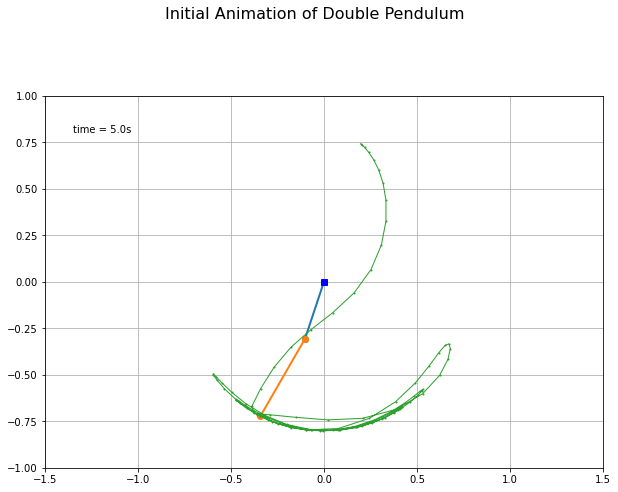

In [8]:
animate_double_pendulum("../plots/statenoise/doubleinitialAnimation.gif", Res1,'Initial Animation of Double Pendulum', T=T, N=N)

## Generate synthetic measurements

In [9]:
# generate synthetic measurements of the states
sigma = [0.001,0.001,0.01,0.01,0.01,0.01]
sigma2 = [0.00001,0.00002,0.0002,0.0001,0.0001,0.0001]
#p_true = [0.1,0.05] defined above
M = L*N
meas = generate_meas(x, p, rhs_exp, L*T, sigma, p_true, M, x0)

In [10]:
# we need to reshape for visualization
meas1 = []
for i in range(M+1):
    meas1 = vertcat(meas1,meas[:,i])
print(meas1.shape)

(606, 1)


MovieWriter Pillow unavailable; using Pillow instead.


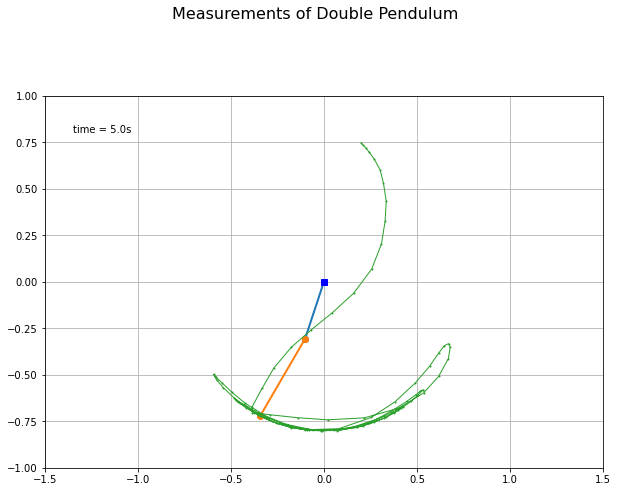

In [11]:
animate_double_pendulum("../plots/statenoise/measurements.gif", meas1,'Measurements of Double Pendulum', T=T, N=N)

## Open loop PE for the first MHE time horizon only 
here the first N=10 shooting intervals (->11 measurements)

In [12]:
x_opt = 0
p_opt = 0
last_P = 0
last_W = 0

#print(meas[:,M])
FF1, FF2 = MS_functions_MHE(T, N, x, p, rhs_exp, meas[:,0:11], sigma,sigma2, x_opt, p_opt, last_P, last_W)

In [13]:
p0= [0,0]
w0 = vertcat(meas1[:x.shape[0]*(N+1)],np.zeros(x.shape[0]*N))
w0 = vertcat(w0,p0)
w = MX.sym('w',w0.shape[0])
#k=0
y = meas[:,10]
#print(y.shape)
F1 = Function('F1',[w],[FF1(w,y)])
F2 = Function('F2',[w],[FF2(w,y)])

In [14]:
w_opt = cnlls_solver(F1, F2, w0, itmax=10, tol=1e-7, ggn = False, show_iteration = False)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)        40
       nlp_g  | 202.00ms (  5.05ms) 203.03ms (  5.08ms)        40
  nlp_grad_f  |   5.00ms (416.67us)   5.07ms (422.33us)        12
  nlp_hess_l  |   1.90 s (189.70ms)   1.89 s (189.38ms)        10
   nlp_jac_g  | 988.00ms ( 82.33ms) 990.16ms ( 82.51ms)        12
       total  |   3.11 s (  3.11 s)   3.11 s (  3.11 s)         1


In [15]:
leng = w_opt.shape[0]
pp_opt = w_opt[leng-p.shape[0]:]
vv_opt = w_opt[(N+1)*x.shape[0]:leng-p.shape[0]]
ss_opt = w_opt[0:(N+1)*x.shape[0]]
print(pp_opt)
print(ss_opt.shape)

[0.01327021 0.18251475]
(66,)


MovieWriter Pillow unavailable; using Pillow instead.


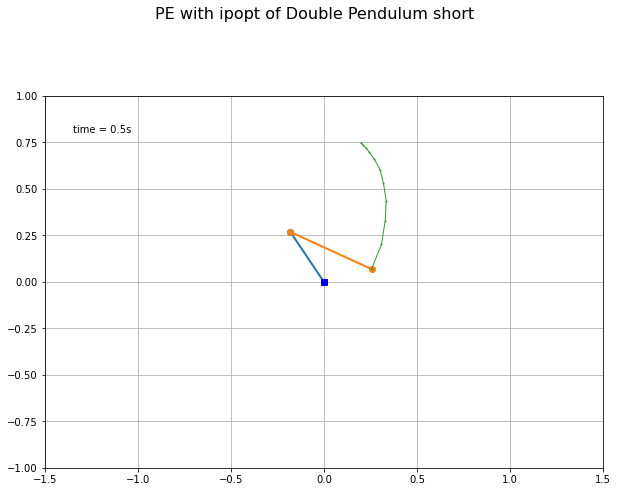

In [16]:
animate_double_pendulum("../plots/statenoise/ipopt_short.gif", ss_opt,'PE with ipopt of Double Pendulum short', T=T, N=N)

## Open loop PE for all measurements

In [17]:
#p0 = [0,0]
x_opt = 0
p_opt = 0
last_P = 0
last_W = 0

#print(meas[:,M])
FF1, FF2 = MS_functions_MHE(L*T, L*N, x, p, rhs_exp, meas, sigma,sigma2, x_opt, p_opt, last_P, last_W)

In [18]:
p0= [0,0]
w0 = vertcat(meas1,np.zeros(N*L*x.shape[0]))
w0 = vertcat(w0,p0)
ww = MX.sym('ww',w0.shape[0])
#k=0
y = meas[:,M]
#print(y.shape)
F1 = Function('F1',[ww],[FF1(ww,y)])
F2 = Function('F2',[ww],[FF2(ww,y)])
#print(F1)
#print(F2)

In [19]:
w_opt = cnlls_solver(F1, F2, w0, itmax=10 , tol=1e-7, ggn = False, show_iteration = False)

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)         6
       nlp_g  | 197.00ms ( 32.83ms) 196.62ms ( 32.77ms)         6
  nlp_grad_f  |   2.00ms (285.71us)   1.58ms (225.86us)         7
  nlp_hess_l  |   7.74 s (  1.55 s)   7.74 s (  1.55 s)         5
   nlp_jac_g  |   5.45 s (778.14ms)   5.45 s (778.40ms)         7
       total  |  13.40 s ( 13.40 s)  13.40 s ( 13.40 s)         1


In [20]:
#print(w_opt)
#cut = int(L*N)
len_w = w_opt.shape[0]
p_opt = w_opt[len_w-p.shape[0]:]
v_opt = w_opt[(L*N+1)*x.shape[0]:len_w-p.shape[0]]
s_opt = w_opt[0:(L*N+1)*x.shape[0]]

In [21]:
print(p_opt)
print(v_opt.shape)
print(s_opt.shape)

[-0.35411118 -0.12020452]
(600,)
(606,)


MovieWriter Pillow unavailable; using Pillow instead.


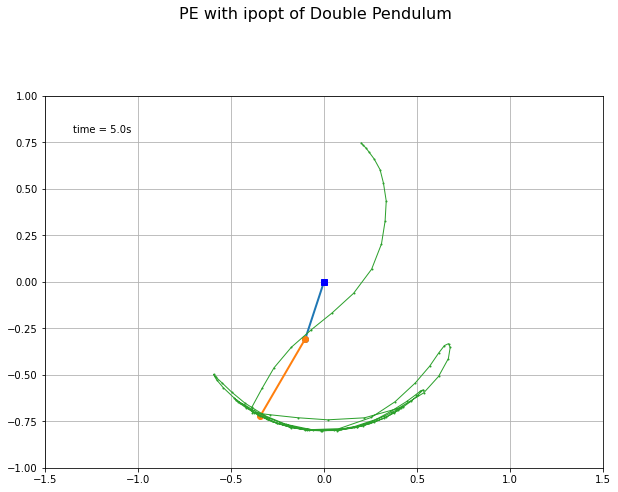

In [22]:
animate_double_pendulum("../plots/statenoise/ipopt.gif", s_opt,'PE with ipopt of Double Pendulum', T=T, N=N)

# MHE

In [25]:
#x_opt = 0
#p_opt = 0
last_P = 0
last_W = 0


x0bar = 0
p0bar = 0
P = 0
p0 = [0.,0.]
r0 = vertcat(meas1[:(N+1)*x.shape[0]],np.zeros(N*x.shape[0]))
r0 = vertcat(r0,p0)
print(r0.shape)
T = 0.5
N = 10
length_simulation = 15
#sigma = 0.01 (defined above)
W = 0

(128, 1)


In [26]:
xx, pp = MHE(x0bar, p0bar, P, r0, T, N, length_simulation, x, p, rhs_exp, meas, sigma,sigma2, W, ggn = False)

starting (time horizon) loop no.  1
rk- shape:  (128, 1)
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)         2
       nlp_g  |        0 (       0)        0 (       0)         2
  nlp_grad_f  |        0 (       0)        0 (       0)         3
  nlp_hess_l  | 255.00ms (255.00ms) 255.23ms (255.23ms)         1
   nlp_jac_g  | 251.00ms ( 83.67ms) 250.90ms ( 83.63ms)         3
       total  | 508.00ms (508.00ms) 508.13ms (508.13ms)         1
starting (time horizon) loop no.  2
rk- shape:  (128, 1)


At t = 0.00585036, mxstep steps taken before reaching tout.
CasADi -  WARNING("solver:nlp_g failed:Error in Function::operator() for 'nlp_g' [MXFunction] at .../casadi/core/function.cpp:1368:
Error in Function::operator() for 'F2' [MXFunction] at .../casadi/core/function.cpp:1368:
Error in Function::operator() for 'F2' [MXFunction] at .../casadi/core/function.cpp:1368:
Error in Function::operator() for 'F' [CvodesInterface] at .../casadi/core/function.cpp:1368:
.../casadi/interfaces/sundials/cvodes_interface.cpp:392: CVode returned "CV_TOO_MUCH_WORK". Consult CVODES documentation.") [.../casadi/core/oracle_function.cpp:223]


      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)         4
       nlp_g  | 138.00ms ( 27.60ms) 137.44ms ( 27.49ms)         5
  nlp_grad_f  |        0 (       0)        0 (       0)         3
  nlp_hess_l  | 288.00ms (288.00ms) 288.06ms (288.06ms)         1
   nlp_jac_g  | 288.00ms ( 96.00ms) 288.22ms ( 96.07ms)         3
       total  | 724.00ms (724.00ms) 724.40ms (724.40ms)         1
starting (time horizon) loop no.  3
rk- shape:  (128, 1)
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)         2
       nlp_g  |  14.00ms (  7.00ms)  13.64ms (  6.82ms)         2
  nlp_grad_f  |        0 (       0)        0 (       0)         3
  nlp_hess_l  | 392.00ms (392.00ms) 391.87ms (391.87ms)         1
   nlp_jac_g  | 357.00ms (119.00ms) 357.10ms (119.03ms)         3
       total  | 763.00ms (763.00ms) 762.62ms (762.62ms)         1
starting (time hori

At t = 0.0142478, mxstep steps taken before reaching tout.
CasADi -  WARNING("solver:nlp_g failed:Error in Function::operator() for 'nlp_g' [MXFunction] at .../casadi/core/function.cpp:1368:
Error in Function::operator() for 'F2' [MXFunction] at .../casadi/core/function.cpp:1368:
Error in Function::operator() for 'F2' [MXFunction] at .../casadi/core/function.cpp:1368:
Error in Function::operator() for 'F' [CvodesInterface] at .../casadi/core/function.cpp:1368:
.../casadi/interfaces/sundials/cvodes_interface.cpp:392: CVode returned "CV_TOO_MUCH_WORK". Consult CVODES documentation.") [.../casadi/core/oracle_function.cpp:223]
At t = 0.0280824, mxstep steps taken before reaching tout.
CasADi -  WARNING("solver:nlp_g failed:Error in Function::operator() for 'nlp_g' [MXFunction] at .../casadi/core/function.cpp:1368:
Error in Function::operator() for 'F2' [MXFunction] at .../casadi/core/function.cpp:1368:
Error in Function::operator() for 'F2' [MXFunction] at .../casadi/core/function.cpp:1368

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)         8
       nlp_g  | 437.00ms ( 39.73ms) 436.59ms ( 39.69ms)        11
  nlp_grad_f  |        0 (       0)        0 (       0)         3
  nlp_hess_l  |   1.32 s (  1.32 s)   1.32 s (  1.32 s)         1
   nlp_jac_g  |   1.20 s (398.67ms)   1.20 s (398.82ms)         3
       total  |   2.95 s (  2.95 s)   2.95 s (  2.95 s)         1
starting (time horizon) loop no.  15
rk- shape:  (128, 1)
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)         4
       nlp_g  | 321.00ms ( 64.20ms) 320.73ms ( 64.15ms)         5
  nlp_grad_f  |        0 (       0)        0 (       0)         3
  nlp_hess_l  |   2.81 s (  2.81 s)   2.81 s (  2.81 s)         1
   nlp_jac_g  |   2.62 s (874.00ms)   2.62 s (874.14ms)         3
       total  |   5.76 s (  5.76 s)   5.76 s (  5.76 s)         1


At t = 0.000760929, mxstep steps taken before reaching tout.
CasADi -  WARNING("solver:nlp_g failed:Error in Function::operator() for 'nlp_g' [MXFunction] at .../casadi/core/function.cpp:1368:
Error in Function::operator() for 'F2' [MXFunction] at .../casadi/core/function.cpp:1368:
Error in Function::operator() for 'F2' [MXFunction] at .../casadi/core/function.cpp:1368:
Error in Function::operator() for 'F' [CvodesInterface] at .../casadi/core/function.cpp:1368:
.../casadi/interfaces/sundials/cvodes_interface.cpp:392: CVode returned "CV_TOO_MUCH_WORK". Consult CVODES documentation.") [.../casadi/core/oracle_function.cpp:223]


MovieWriter Pillow unavailable; using Pillow instead.


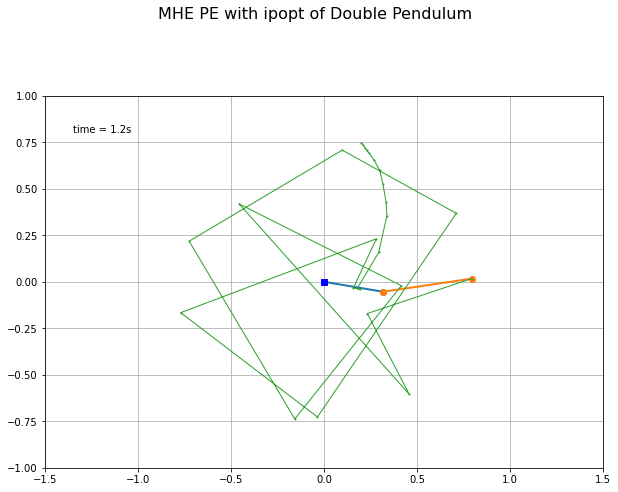

In [27]:
animate_double_pendulum("../plots/statenoise/mhe.gif", xx,'MHE PE with ipopt of Double Pendulum', T=T, N=N)

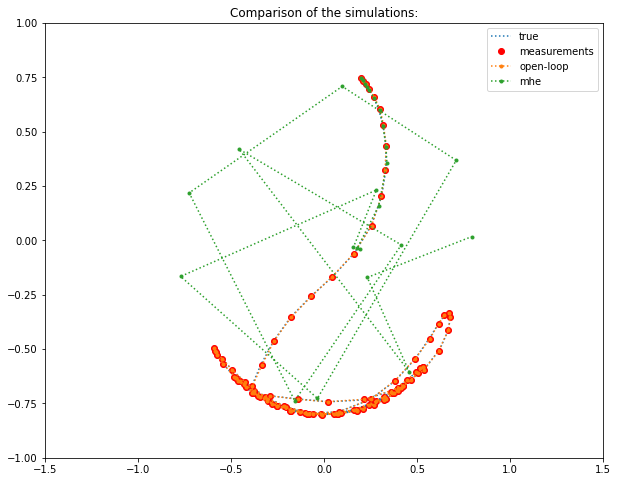

In [28]:
plt.figure(figsize=(10,8))
plt.title("Comparison of the simulations:")
plt.xlim(-1.5,1.5)
plt.ylim(-1.,1.)

ss = Res1 # true
s = np.array(ss).flatten()
ll = int(s.shape[0]/6)
x3 = np.array([get_ball2_x(s[6*i:6*(i+1)]) for i in range(ll)])
y3 = np.array([get_ball2_y(s[6*i:6*(i+1)]) for i in range(ll)])
plt.plot(x3,y3,linestyle = 'dotted', label = "true")   

ss = Res2 # true comp
s = np.array(ss).flatten()
ll = int(s.shape[0]/6)
x3 = np.array([get_ball2_x(s[6*i:6*(i+1)]) for i in range(ll)])
y3 = np.array([get_ball2_y(s[6*i:6*(i+1)]) for i in range(ll)])
#plt.plot(x3,y3,linestyle = 'dotted', label = "true comp")   

ss = meas1 # meas
s = np.array(ss).flatten()
ll = int(s.shape[0]/6)
x3 = np.array([get_ball2_x(s[6*i:6*(i+1)]) for i in range(ll)])
y3 = np.array([get_ball2_y(s[6*i:6*(i+1)]) for i in range(ll)])
plt.plot(x3,y3, 'ro',label = "measurements")#, linestyle = 'dotted') 

ss = s_opt # open-loop
s = np.array(ss).flatten()
ll = int(s.shape[0]/6)
x3 = np.array([get_ball2_x(s[6*i:6*(i+1)]) for i in range(ll)])
y3 = np.array([get_ball2_y(s[6*i:6*(i+1)]) for i in range(ll)])
plt.plot(x3,y3,marker = 'o', label = "open-loop", linestyle = 'dotted', ms = 3) 

ss = ss_opt # open-loop short
s = np.array(ss).flatten()
ll = int(s.shape[0]/6)
x3 = np.array([get_ball2_x(s[6*i:6*(i+1)]) for i in range(ll)])
y3 = np.array([get_ball2_y(s[6*i:6*(i+1)]) for i in range(ll)])
#plt.plot(x3,y3,marker = 'o', label = "open-loop short", linestyle = 'dotted', ms = 3) 

ss = xx # mhe
s = np.array(ss).flatten()
ll = int(s.shape[0]/6)
x3 = np.array([get_ball2_x(s[6*i:6*(i+1)]) for i in range(ll)])
y3 = np.array([get_ball2_y(s[6*i:6*(i+1)]) for i in range(ll)])
plt.plot(x3,y3,marker = 'o', label = "mhe", linestyle = 'dotted', ms = 3)   
plt.legend()

In [29]:
def plot_widget(simulations): #, n):
    plt.figure(figsize=(10,8))
    plt.title("Comparison of the simulations:")
    plt.xlim(-1.5,1.5)
    plt.ylim(-1.,1.)
    
    
    if 'true' in simulations:
        ss = Res1 # true
        s = np.array(ss).flatten()
        ll = int(s.shape[0]/6)
        x3 = np.array([get_ball2_x(s[6*i:6*(i+1)]) for i in range(ll)])
        y3 = np.array([get_ball2_y(s[6*i:6*(i+1)]) for i in range(ll)])
        plt.plot(x3,y3,linestyle = 'dotted', label = "true")   

        
    if 'measured' in simulations:
        ss = meas1 # meas
        s = np.array(ss).flatten()
        ll = int(s.shape[0]/6)
        x3 = np.array([get_ball2_x(s[6*i:6*(i+1)]) for i in range(ll)])
        y3 = np.array([get_ball2_y(s[6*i:6*(i+1)]) for i in range(ll)])
        plt.plot(x3,y3, 'ro',label = "measurements", ms = 5)#, linestyle = 'dotted') 
        
    if 'open-loop' in simulations:
        ss = s_opt # open-loop
        s = np.array(ss).flatten()
        ll = int(s.shape[0]/6)
        x3 = np.array([get_ball2_x(s[6*i:6*(i+1)]) for i in range(ll)])
        y3 = np.array([get_ball2_y(s[6*i:6*(i+1)]) for i in range(ll)])
        plt.plot(x3,y3,marker = 'o', label = "open-loop", linestyle = 'dotted', ms = 3) 
        
    if 'open-loop short' in simulations:
        ss = ss_opt # open-loop short
        s = np.array(ss).flatten()
        ll = int(s.shape[0]/6)
        x3 = np.array([get_ball2_x(s[6*i:6*(i+1)]) for i in range(ll)])
        y3 = np.array([get_ball2_y(s[6*i:6*(i+1)]) for i in range(ll)])
        plt.plot(x3,y3,marker = 'o', label = "open-loop short", linestyle = 'dotted', ms = 3) 
        
    if 'mhe' in simulations:
        ss = xx # mhe
        s = np.array(ss).flatten()
        ll = int(s.shape[0]/6)
        x3 = np.array([get_ball2_x(s[6*i:6*(i+1)]) for i in range(ll)])
        y3 = np.array([get_ball2_y(s[6*i:6*(i+1)]) for i in range(ll)])
        plt.plot(x3,y3,marker = 'o', label = "mhe", linestyle = 'dotted', ms = 3)  
        
    plt.legend()
    plt.show()

In [30]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
#from animate_double import plot_widget


interactive(plot_widget, simulations = widgets.SelectMultiple(
    options=['true', 'measured', 'open-loop', 'open-loop short','mhe'],
    rows = 5,
    description='Simulations:',
    disabled=False
))

interactive(children=(SelectMultiple(description='Simulations:', options=('true', 'measured', 'open-loop', 'op…

In [31]:
print(pp[pp.shape[0]-2:])
print(pp.shape)
#print(xx.shape)

[-9.40271, 2.10927]
(30, 1)


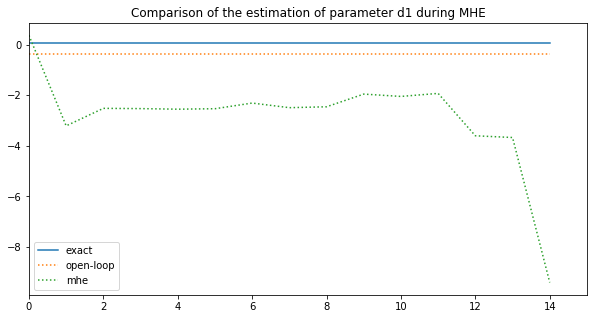

In [35]:
p_plot1 = pp[::2]
#print(p_opt[0])
p_ref1 = p_true[0]*np.ones(p_plot1.size()[0])
p_open_loop1 = p_opt[0]*np.ones(p_plot1.size()[0])

x_ax = range(p_plot1.size()[0]) 
plt.figure(figsize=(10,5))
plt.plot(x_ax,p_ref1, label = 'exact')
plt.plot(x_ax, p_open_loop1, label = 'open-loop', linestyle='dotted')
plt.plot(x_ax, p_plot1, label = 'mhe', linestyle='dotted')
plt.title('Comparison of the estimation of parameter d1 during MHE')
plt.xlim(0,p_plot1.size()[0])
#plt.ylim(p_true[0]-0.3,p_true[0]+0.3) #plt.ylim(-0.4,0.1)
plt.legend()

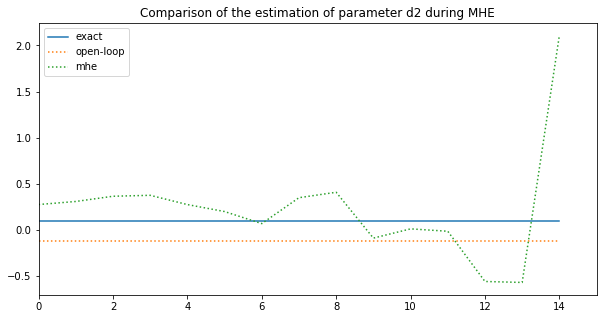

In [36]:
p_plot2 = pp[1::2]
#print(p_plot)
p_ref2 = p_true[1]*np.ones(p_plot2.size()[0])
p_open_loop2 = p_opt[1]*np.ones(p_plot2.size()[0])

x_ax = range(p_plot2.size()[0]) 
plt.figure(figsize=(10,5))
plt.plot(x_ax,p_ref2, label = 'exact')
plt.plot(x_ax, p_open_loop2, label = 'open-loop', linestyle='dotted')
plt.plot(x_ax, p_plot2, label = 'mhe', linestyle= 'dotted')
plt.title('Comparison of the estimation of parameter d2 during MHE')
plt.xlim(0,p_plot2.size()[0])
#plt.ylim(p_true[1]-0.3,p_true[1]+0.3)#plt.ylim(-0.2,0.3) ## Attention works only for this special choice of parameter!
plt.legend()

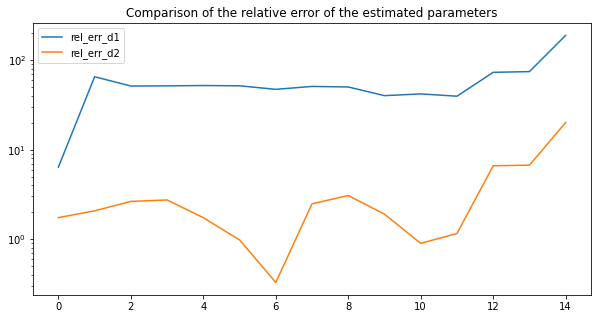

In [37]:
## relative error
## for d1:
rel_err1 = np.zeros(p_plot1.size()[0])
for i in x_ax:
    rel_err1[i]=np.abs(p_plot1[i]-p_ref1[i])/p_ref1[i]
    #rel_err1.append(np.abs(p_plot1[i]-p_ref[i])/p_ref[i])
#print(rel_err1)

## for d1:
rel_err2 = np.zeros(p_plot2.size()[0])
for i in x_ax:
    rel_err2[i]=np.abs(p_plot2[i]-p_ref2[i])/p_ref2[i]
    #rel_err1.append(np.abs(p_plot1[i]-p_ref[i])/p_ref[i])
#print(rel_err2)

plt.figure(figsize=(10,5))
plt.plot(x_ax, rel_err1, label='rel_err_d1')
plt.plot(x_ax, rel_err2, label = 'rel_err_d2')
plt.yscale('log')
plt.title('Comparison of the relative error of the estimated parameters')
plt.legend()